In [ ]:
import pandas as pd
import numpy as np

In [ ]:
! cp /content/drive/MyDrive/gin_depmap_transfer_learning/normalized_no_leakage.zip .
! unzip normalized_no_leakage.zip

Archive:  normalized_no_leakage.zip
  inflating: depmap_crispr_zscore.csv  
  inflating: depmap_expression_lfc_zscore.csv  
  inflating: hap1_expression_lfc.csv  
  inflating: hap1_crispr.csv         


In [ ]:
# ! cp /content/drive/MyDrive/gin_depmap_transfer_learning/depmap_tissue_normalized.zip .
# ! unzip depmap_tissue_normalized.zip

In [ ]:
norm_dir = ""

hap1_expression_lfc = pd.read_csv(norm_dir + "hap1_expression_lfc.csv", index_col=0)
hap1_crispr = pd.read_csv(norm_dir + "hap1_crispr.csv", index_col=0)
depmap_expression_lfc_zscore = pd.read_csv(norm_dir + "depmap_expression_lfc_zscore.csv", index_col=0)
depmap_crispr_zscore = pd.read_csv(norm_dir + "depmap_crispr_zscore.csv", index_col=0)
# depmap_expression_lfc_tissue_zscore = pd.read_csv(norm_dir + "depmap_expression_lfc_tissue_zscore.csv", index_col=0)
# depmap_crispr_tissue_zscore = pd.read_csv(norm_dir + "depmap_crispr_tissue_zscore.csv", index_col=0)
# hap1_expression_lfc.shape, hap1_crispr.shape, depmap_expression_lfc_tissue_zscore.shape, depmap_crispr_tissue_zscore.shape
hap1_expression_lfc.shape, hap1_crispr.shape, depmap_expression_lfc_zscore.shape, depmap_crispr_zscore.shape

((60, 16372), (60, 16432), (1021, 16372), (1021, 16432))

In [ ]:
! cp /content/drive/MyDrive/gin_depmap_transfer_learning/tcga_expression_lfc_zscore.csv.zip .
! unzip tcga_expression_lfc_zscore.csv.zip

Archive:  tcga_expression_lfc_zscore.csv.zip
  inflating: tcga_expression_lfc_zscore.csv  


In [ ]:
tcga_expression_lfc_zscore = pd.read_csv(norm_dir + "tcga_expression_lfc_zscore.csv", index_col=0)

In [ ]:
tcga_expression_lfc_zscore.shape

(10534, 16372)

In [ ]:
def evaluate_Challenge_B(df_true, df_score, method='pearson'):
    score_list = []
    df_true = df_true.values
    df_score = df_score.values
    for i in range(df_score.shape[1]):
        y_pred = df_score[:, i]
        y_true = df_true[:, i]
        score_list.append(np.corrcoef(y_true, y_pred)[0, 1])
    return score_list

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def analyze_predictions(pred, true, plot=False, transpose=False, bins=100):
    if transpose:
        true = true.T
        pred = pred.T
    score_list = evaluate_Challenge_B(true, pred)
    score_list = [score if not np.isnan(score) else 0 for score in score_list]
    mean = np.mean(score_list)
    print("Mean corr:", mean)
    mse = mean_squared_error(true, pred)
    print("Mean mse:", mse)
    print("Prop > 0.1:", np.mean([1 if score > 0.1 else 0 for score in score_list]))
    print("Prop > 0.2:", np.mean([1 if score > 0.2 else 0 for score in score_list]))
    print("Prop > 0.3:", np.mean([1 if score > 0.3 else 0 for score in score_list]))
    if plot:
        plt.figure(figsize=(10, 5), dpi=200)
        plt.hist(score_list, bins=bins)
        plt.axvline(x=mean, color='red')
        plt.xlim(-1, 1)
        plt.show()

In [ ]:
def pcc_thresholded(pred, actual, threshold=2, plot=False):
    select = (np.abs(pred) >= threshold) & (np.abs(actual) >= threshold)
    if plot:
        plt.scatter(pred, actual)
        plt.show()
        plt.scatter(pred[select], actual[select])
        plt.show()
    return np.corrcoef(pred[select], actual[select])[0, 1]

In [ ]:
def zscore(df):
    return pd.DataFrame(
        StandardScaler().fit_transform(df),
        index=df.index,
        columns=df.columns,
    )

In [ ]:
high_var = pd.read_csv("high_var3.txt", header=None).values.flatten()
len(high_var)

100

In [ ]:
data = hap1_expression_lfc
labels = hap1_crispr[high_var]
# data2 = depmap_expression_lfc_tissue_zscore
# labels2 = depmap_crispr_tissue_zscore
data2 = depmap_expression_lfc_zscore
labels2 = depmap_crispr_zscore[high_var]

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Mean corr: 0.270883443209305
Mean mse: 1.5096623711821013
Prop > 0.1: 0.79
Prop > 0.2: 0.65
Prop > 0.3: 0.46


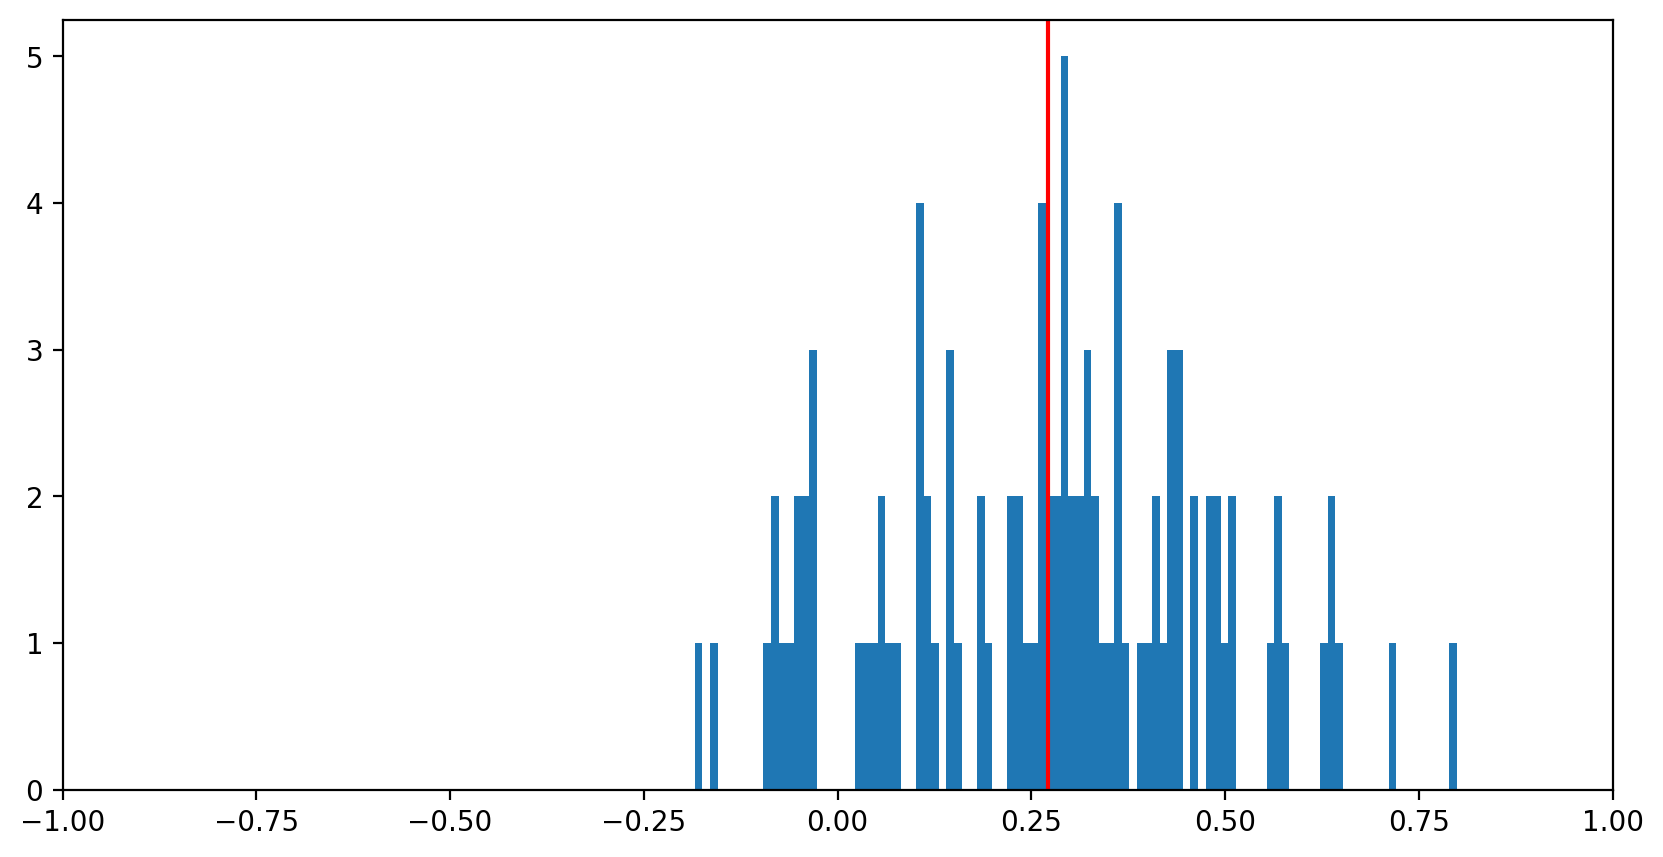

Mean corr: 0.25847929841801404
Mean mse: 1.5096623711821013
Prop > 0.1: 0.7
Prop > 0.2: 0.6
Prop > 0.3: 0.4166666666666667


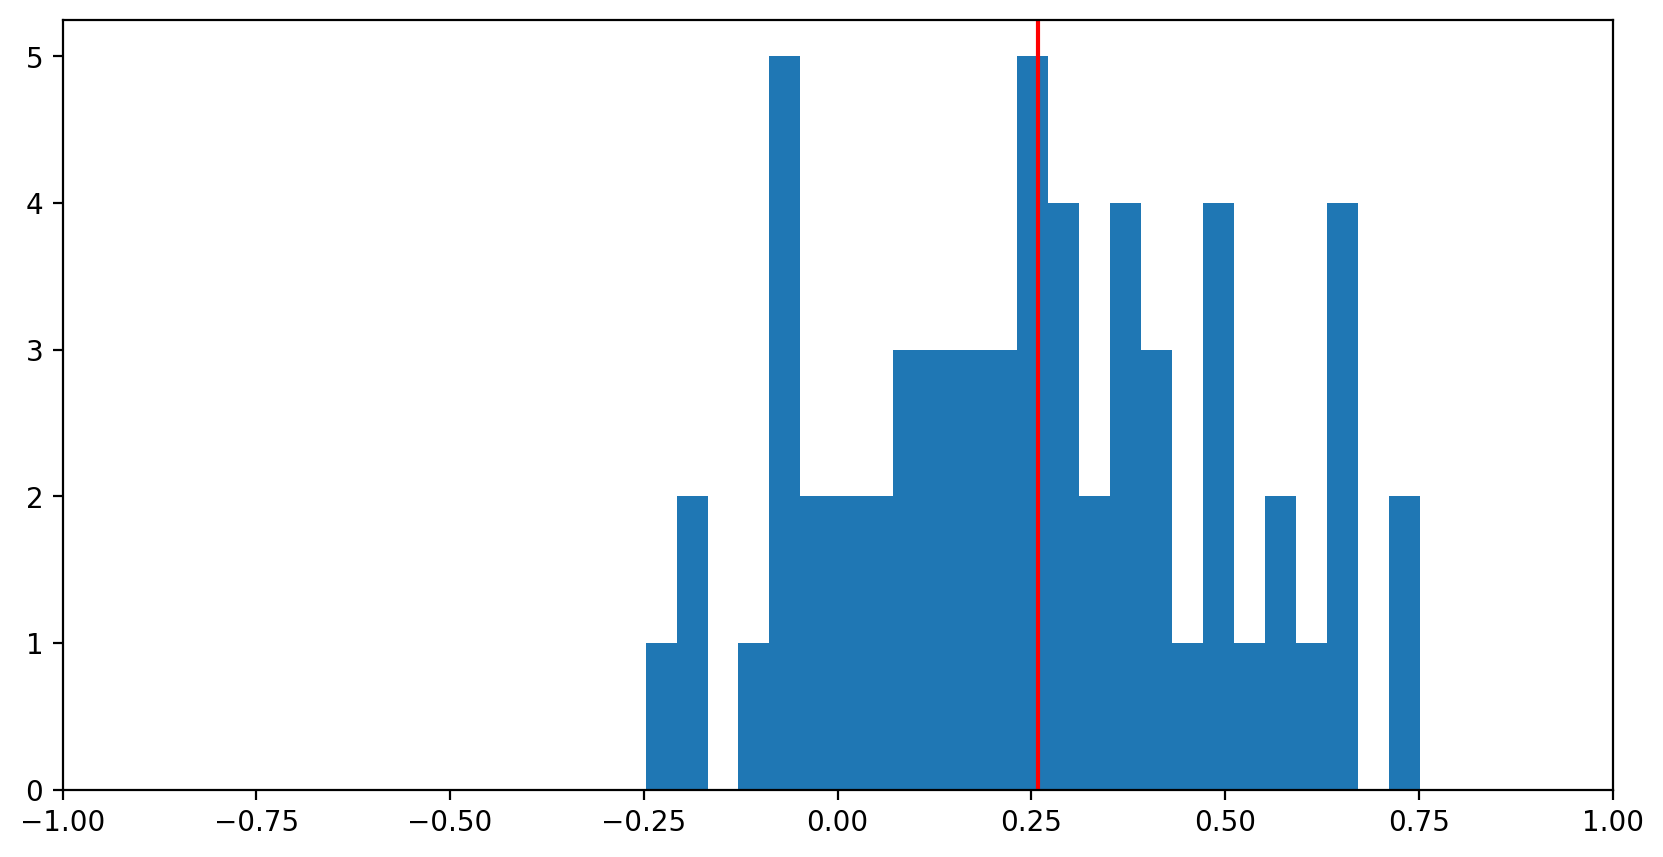

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

pred_list = []
label_list = []

kfold = KFold(10, shuffle=True, random_state=42)
for (train_index, test_index) in tqdm(kfold.split(data), total=10):
# loo = LeaveOneOut()
# for (train_index, test_index) in tqdm(loo.split(data), total=60):

    # pluck out data
    X_train = data.iloc[train_index]
    y_train = labels.iloc[train_index]
    X_test = data.iloc[test_index]
    y_test = labels.iloc[test_index]

    # fit scaler
    x_scaler = StandardScaler()
    x_scaler.fit(X_train)

    y_scaler = StandardScaler()
    y_scaler.fit(y_train)

    # scale features
    X_train = pd.DataFrame(x_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(x_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train = pd.DataFrame(y_scaler.transform(y_train), index=y_train.index, columns=y_train.columns)
    y_test = pd.DataFrame(y_scaler.transform(y_test), index=y_test.index, columns=y_test.columns)

    # augment data
    # X_train = pd.concat([X_train, data2])
    # y_train = pd.concat([y_train, labels2])

    model = Ridge()

    model.fit(X_train, y_train)
    y_pred_curr = model.predict(X_test)

    prediction_df = pd.DataFrame(y_pred_curr, index=y_test.index, columns=y_test.columns)
    label_df = y_test

    pred_list.append(prediction_df)
    label_list.append(label_df)

prediction_df = pd.concat(pred_list)
label_df = pd.concat(label_list)

analyze_predictions(prediction_df, label_df, plot=True)
analyze_predictions(prediction_df, label_df, plot=True, transpose=True, bins=25)

In [ ]:
baseline_corrs = evaluate_Challenge_B(prediction_df, label_df)
len(baseline_corrs)

100

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=4096, latent_dim=128):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc1_bn = nn.BatchNorm1d(hidden_dim)

        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_mu_bn = nn.BatchNorm1d(latent_dim)

        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logbar_bn = nn.BatchNorm1d(latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc3_bn = nn.BatchNorm1d(hidden_dim)

        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.fc4_bn = nn.BatchNorm1d(input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1_bn(self.fc1(x)))
        mu = self.fc2_mu_bn(self.fc2_mu(h1))
        logvar = self.fc2_logbar_bn(self.fc2_logvar(h1))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3_bn(self.fc3(z)))
        return self.fc4_bn(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, beta):
    # MSE Loss
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL Divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + beta * kld_loss

In [ ]:
hap1_expression_lfc_zscore = zscore(hap1_expression_lfc)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

def get_dataloader(df, shuffle=True):
    dataset = TensorDataset(torch.tensor(df.values).float().cuda())
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = get_dataloader(pd.concat([tcga_expression_lfc_zscore, depmap_expression_lfc_zscore]), shuffle=True)
test_loader = get_dataloader(depmap_expression_lfc_zscore, shuffle=False)

In [ ]:
mse = nn.MSELoss()

In [ ]:
depmap_expression_lfc_zscore.shape[1]

16372

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
2 ** 14, 2 ** 15,

(16384, 32768)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# optimize layer sizes in cross validation!
model = VAE(depmap_expression_lfc_zscore.shape[1], 4096, 128).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 300
num_warmup_epochs = 100

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_mse = 0
    beta = min(1.0, float(epoch) / num_warmup_epochs)
    for (data_,) in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_)
        loss = loss_function(recon_batch, data_, mu, logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        train_mse += mse(recon_batch, data_).item()

    train_loss /= len(train_loader.dataset)
    train_mse /= len(train_loader)

    model.eval()
    test_loss = 0
    test_mse = 0
    with torch.no_grad():
      for (data_,) in test_loader:
        recon_batch, mu, logvar = model(data_)
        loss = loss_function(recon_batch, data_, mu, logvar, beta)
        test_loss += loss.item()
        test_mse += mse(recon_batch, data_).item()

    test_loss /= len(test_loader.dataset)
    test_mse /= len(test_loader)

    print('Epoch: {} \tTrain loss: {:.3f} \t Test loss: {:.3f}'.format(epoch, train_loss, test_loss))
    print('Epoch: {} \tTrain mse: {:.3f} \t Test mse: {:.3f}'.format(epoch, train_mse, test_mse))